c:\Users\Morris\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchxrayvision\utils.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


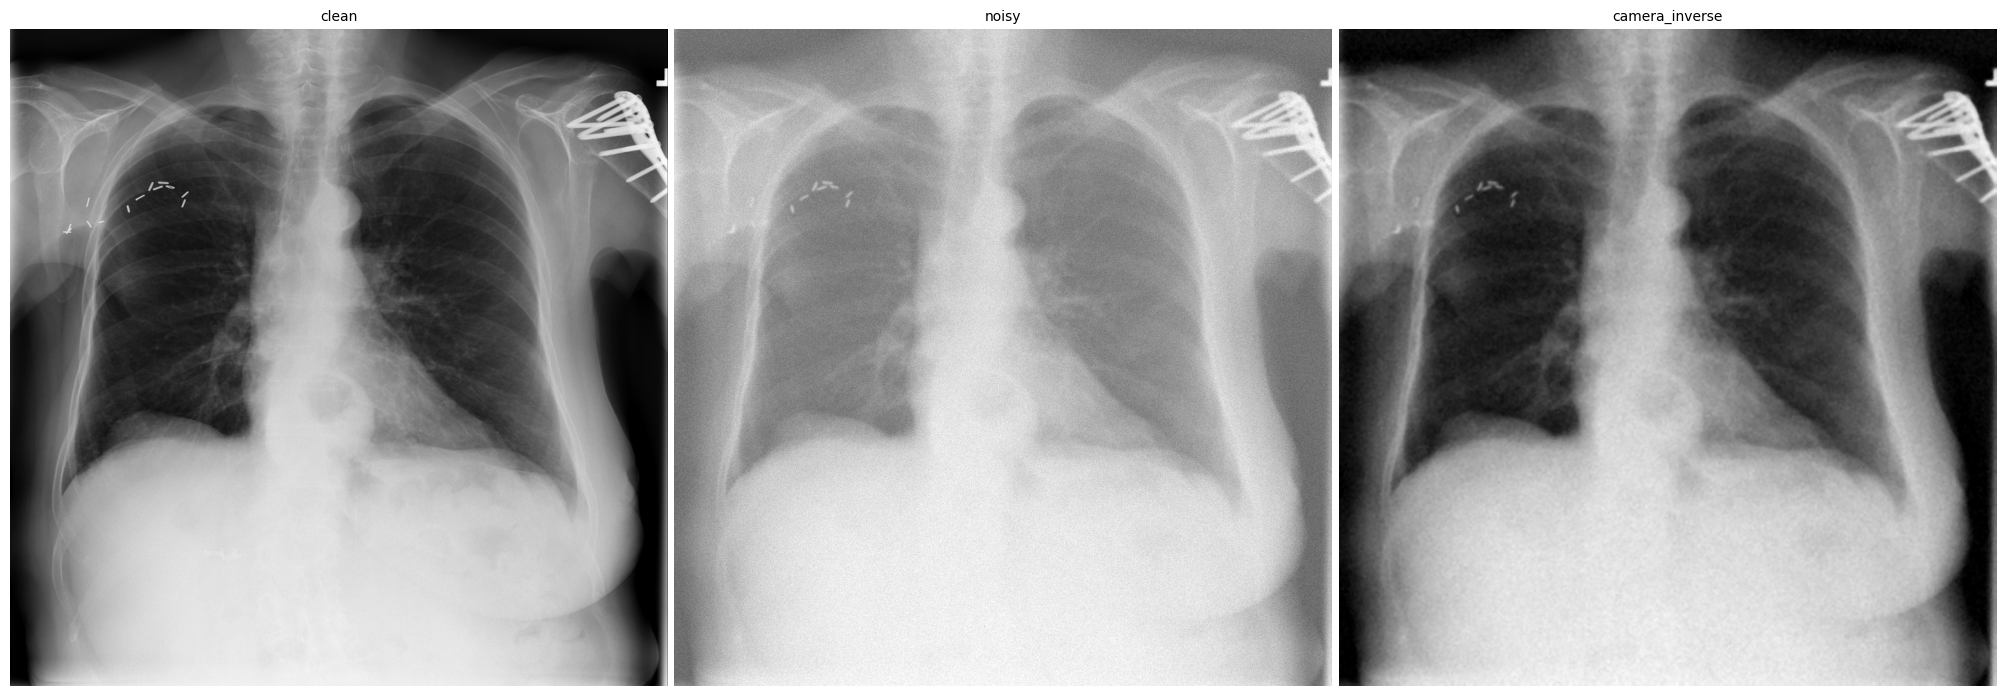

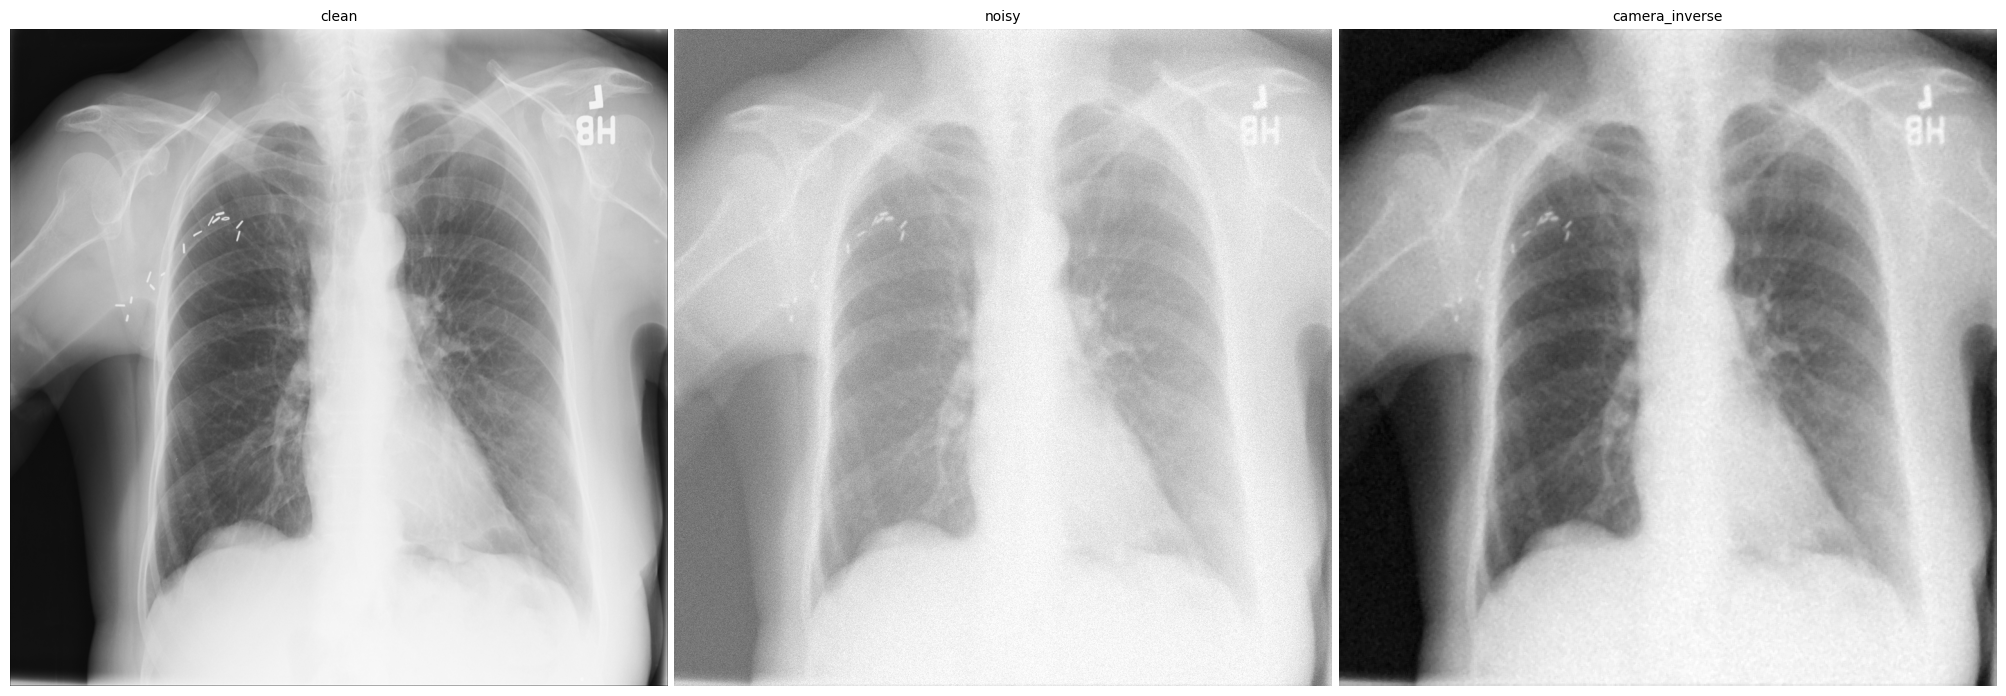

test!


In [ ]:
import oxr_utils as oxr
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn

dataset = oxr.NIH_Dataset("../data/NIH_data", split="test")
dataset = torch.utils.data.Subset(dataset, range(5000)) # only use 2 images for testing
camera_approx = oxr.camera_approx.CameraApprox(1.0)
median_filter = oxr.cxr_processing.MedianFilter(5)
camera_inverse = oxr.camera_approx.CamearApproxInverse(camera_approx)

# Show example images
for i in range(2):
    with torch.no_grad():
        clean = dataset[i][0]
        noisy = camera_approx(clean)
        oxr.plot_cxr_images([clean, noisy, median_filter(camera_inverse(noisy))], ["clean", "noisy", f"camera_inverse median"], figsize=(20, 60)) # show example
        plt.show()
    

print("test!")

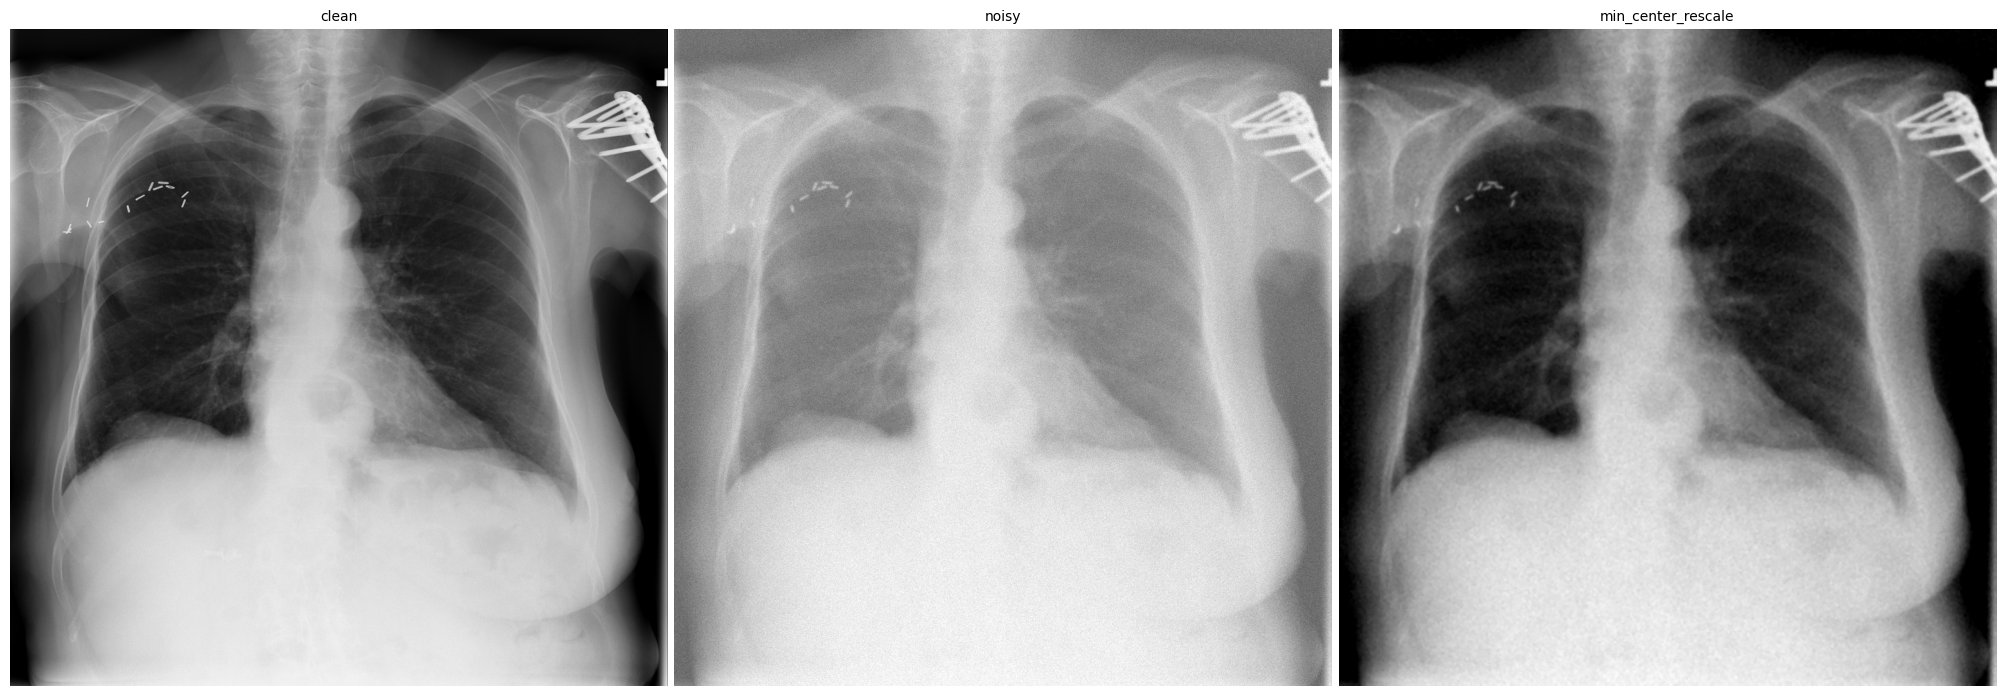

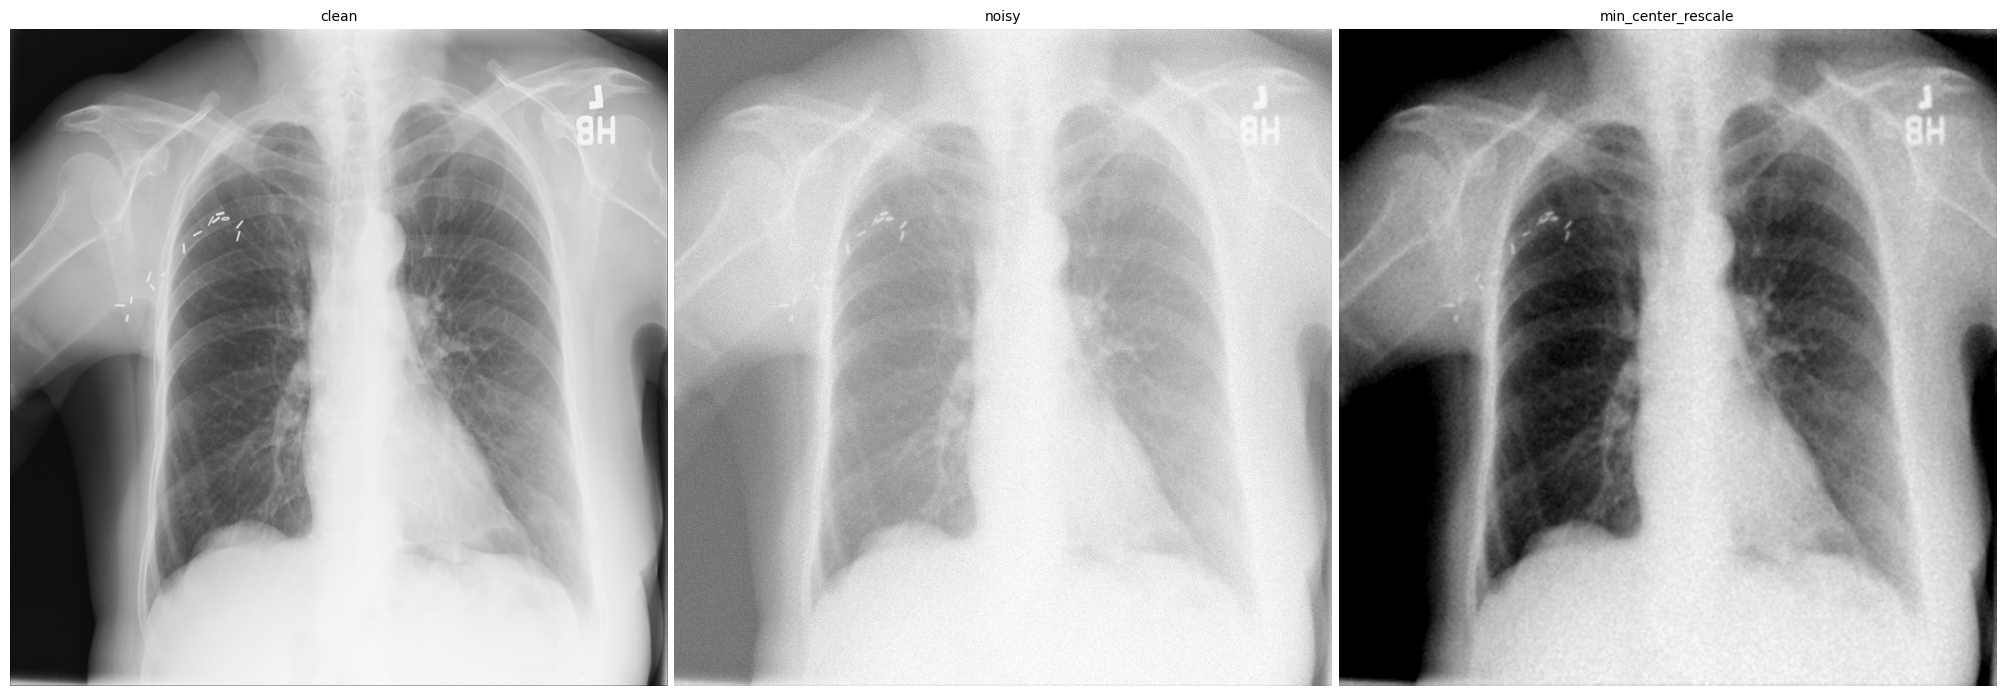

In [2]:
# Naive restoration test

# min center method. Rescale the values so that the minimum of the center 25% of the image is 0, while keeping the global max as 1.0. Then clamp to [0, 1]

import torch
import torch.nn as nn

class MinCenterRescale(nn.Module):
    """
    Rescales input images so that the minimum value in the center 25% becomes 0,
    and the global max becomes 1. Clamps output to [0, 1].

    Supports inputs of shape:
      - (B, C, H, W)
      - (C, H, W)
    """
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        original_shape = x.shape

        # Add batch dim if input is 3D: (C, H, W) → (1, C, H, W)
        if x.dim() == 3:
            x = x.unsqueeze(0)

        if x.dim() != 4:
            raise ValueError(f"Input must be 3D or 4D, but got shape {original_shape}")

        B, C, H, W = x.shape
        h_start, h_end = H // 4, 3 * H // 4
        w_start, w_end = W // 4, 3 * W // 4

        center = x[:, :, h_start:h_end, w_start:w_end]
        center_min = center.amin(dim=(-2, -1), keepdim=True)   # (B, C, 1, 1)
        global_max = x.amax(dim=(-2, -1), keepdim=True)        # (B, C, 1, 1)

        denom = global_max - center_min
        denom[denom == 0] = 1.0  # prevent divide-by-zero

        rescaled = (x - center_min) / denom
        rescaled = rescaled.clamp(0.0, 1.0)

        # If original was 3D, squeeze batch dim back out
        if original_shape == x.shape[1:]:
            return rescaled.squeeze(0)
        return rescaled

min_center_rescale = MinCenterRescale()

for i in range(2):
    with torch.no_grad():
        clean = dataset[i][0]
        noisy = camera_approx(clean)
        
        oxr.plot_cxr_images([clean, noisy, min_center_rescale( median_filter(noisy))], ["clean", "noisy", "min_center_rescale"], figsize=(20, 60)) # show example
        plt.show()



In [ ]:
print(len(dataset))
tester = oxr.NihTester(dataset)
print(tester.diagnosis_model.targets)
# ROCs
rocs_median = tester.rocs(nn.Sequential(camera_approx, median_filter))
print("median:", rocs_median.total_auc_score())   
rocs_median_rs = tester.rocs(nn.Sequential(camera_approx, median_filter, min_center_rescale))
print("rescale(median(x)):", rocs_median_rs.total_auc_score())   
rocs_clean = tester.rocs()
print("clean:", rocs_clean.total_auc_score())    
rocs_noisy = tester.rocs(camera_approx)
print("noisy:", rocs_noisy.total_auc_score())
rocs_cam_inverse_median = tester.rocs(nn.Sequential(camera_approx, camera_inverse, median_filter))
print("cam_inv_median:", rocs_cam_inverse_median.total_auc_score())




5000
['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']


Making ROCs:   0%|          | 0/313 [00:00<?, ?it/s]

Making ROCs:  32%|███▏      | 100/313 [05:08<11:12,  3.16s/it]

In [ ]:

print(f"""
TOTAL AUC: 
  AUC clean:         {rocs_clean.total_auc_score():.4f}
  AUC noisy:         {rocs_noisy.total_auc_score():.4f}
  AUC median:        {rocs_median.total_auc_score():.4f}
  AUC rs median:     {rocs_median_rs.total_auc_score():.4f}
  AUC cam_inv_med:   {rocs_cam_inverse_median.total_auc_score():.4f}

# PATHOLOGY DBREAKDOWN
""")



for i in range(14):
    print(f"""
{rocs_noisy.targets[i] if rocs_noisy.targets else '<none>'}: 
  AUC clean:          {rocs_clean.auc_score(i):.4f}
  AUC noisy:           {rocs_noisy.auc_score(i):.4f}
  AUC median:          {rocs_median.auc_score(i):.4f}
  AUC rs median:       {rocs_median_rs.auc_score(i):.4f}
  AUC cam_inv_median:  {rocs_cam_inverse_median.total_auc_score():.4f}

""")
    fig, ax = oxr.setup_roc_plot(f"{rocs_noisy.targets[i] if rocs_noisy.targets else '<none>'}")
    oxr.add_roc_curve(ax, rocs_clean.roc_fpr_tpr(i), f"Clean {rocs_noisy.targets[i] if rocs_noisy.targets else ''}", color="red",  linestyle="-",auc_in_label=True)
    oxr.add_roc_curve(ax, rocs_noisy.roc_fpr_tpr(i), f"Noisy {rocs_noisy.targets[i] if rocs_noisy.targets else ''}", color="gray", linestyle=":",auc_in_label=True)
    oxr.add_roc_curve(ax, rocs_median.roc_fpr_tpr(i), f"Median {rocs_noisy.targets[i] if rocs_noisy.targets else ''}", color="blue",  linestyle="--",auc_in_label=True)
    oxr.add_roc_curve(ax, rocs_median_rs.roc_fpr_tpr(i), f"Rescale Median {rocs_noisy.targets[i] if rocs_noisy.targets else ''}", color="green", linestyle="--",auc_in_label=True)
    oxr.add_roc_curve(ax, rocs_cam_inverse_median.roc_fpr_tpr(i), f"Inverse Median {rocs_noisy.targets[i] if rocs_noisy.targets else ''}", color="yellow", linestyle="--",auc_in_label=True)
    oxr.finalize_roc_plot(ax)
    plt.show()